In [1]:
# Topic: Omedna Plant Disease Classsification
# Author: Hariharan Ayappane
# Date: 28/8/23
# Descripion: 
# 1. The below notebook explores the application of ensembling in imae classification problems. 
# 2. The base models are Sequential, ResNet50 and InceptionV3
# 3. The base models are ensembled using averaging. But more advanced methods like Ridge Regression can be used as well.
# 4. Hyperparameter tuning is in pending  
# 5. Dataset used is from Strategy 002 (Single leaves)
# 6. Accuracies obtained are as follows (approx):
#     a. Sequential: 72.22
#     b. ResNet50: 80.09
#     c. InceptionV3:  89.81
#     d. Ensemble: 90.98

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

C:\Users\haria\anaconda3\envs\deployment\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\haria\anaconda3\envs\deployment\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\haria\anaconda3\envs\deployment\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
from PIL import Image
from sklearn.preprocessing import LabelEncoder

In [4]:
from tensorflow.python.client import device_lib

In [5]:
import numpy as np
import pandas as pd

In [6]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential

#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob

In [7]:
import matplotlib.pyplot as plt

In [8]:
IMAGE_SIZE = 256
CHANNELS = 3

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [10]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [11]:
def get_all_predictions(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    return predictions[0]

In [12]:
# ['Cescospora', 'Healthy', 'Miner', 'Phoma', 'Rust']

In [13]:
def find_class(label):
    if (label == [1, 0, 0, 0, 0]).all():
        return "Cescospora"
    elif (label == [0, 1, 0, 0, 0]).all():
        return "Healthy"
    elif (label == [0, 0, 1, 0, 0]).all():
        return "Miner"
    elif (label == [0, 0, 0, 1, 0]).all():
        return "Phoma"
    else :
        return "Rust"

In [14]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6656094702472589745
]


# Model 1: Sequential

In [16]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'data2/output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 134 images belonging to 5 classes.


In [17]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'data2/output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse",
)

Found 1047 images belonging to 5 classes.


In [18]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'data2/output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="sparse"
)

Found 130 images belonging to 5 classes.


In [19]:
class_names = train_generator.class_indices
class_names = list(class_names.keys())

In [20]:
class_names

['Cescospora', 'Healthy', 'Miner', 'Phoma', 'Rust']

In [21]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model1 = models.Sequential([
    layers.InputLayer(input_shape=input_shape),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [23]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
steps = 1047//32

In [265]:
history = model1.fit(
    train_generator,
    steps_per_epoch=steps,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=5,
)

Epoch 1/5
32/32 [==============================] - 114s 4s/step - loss: 1.4604 - accuracy: 0.3862 - val_loss: 1.3579 - val_accuracy: 0.4077
Epoch 2/5
32/32 [==============================] - 112s 4s/step - loss: 1.2180 - accuracy: 0.4768
Epoch 3/5
32/32 [==============================] - 104s 3s/step - loss: 1.0834 - accuracy: 0.5281
Epoch 4/5
32/32 [==============================] - 107s 3s/step - loss: 1.0462 - accuracy: 0.5576
Epoch 5/5
32/32 [==============================] - 108s 3s/step - loss: 1.0083 - accuracy: 0.5862


In [194]:
scores = model1.evaluate(test_generator)

5/5 [==============================] - 10s 2s/step - loss: 1.0352 - accuracy: 0.5672


[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]
[4. 2. 0. 2. 0. 2. 4. 4. 4. 2. 4. 4. 2. 4. 4. 4. 1. 0. 0. 4. 1. 1. 4. 1.
 4. 2. 2. 3. 2. 4. 0. 1.]


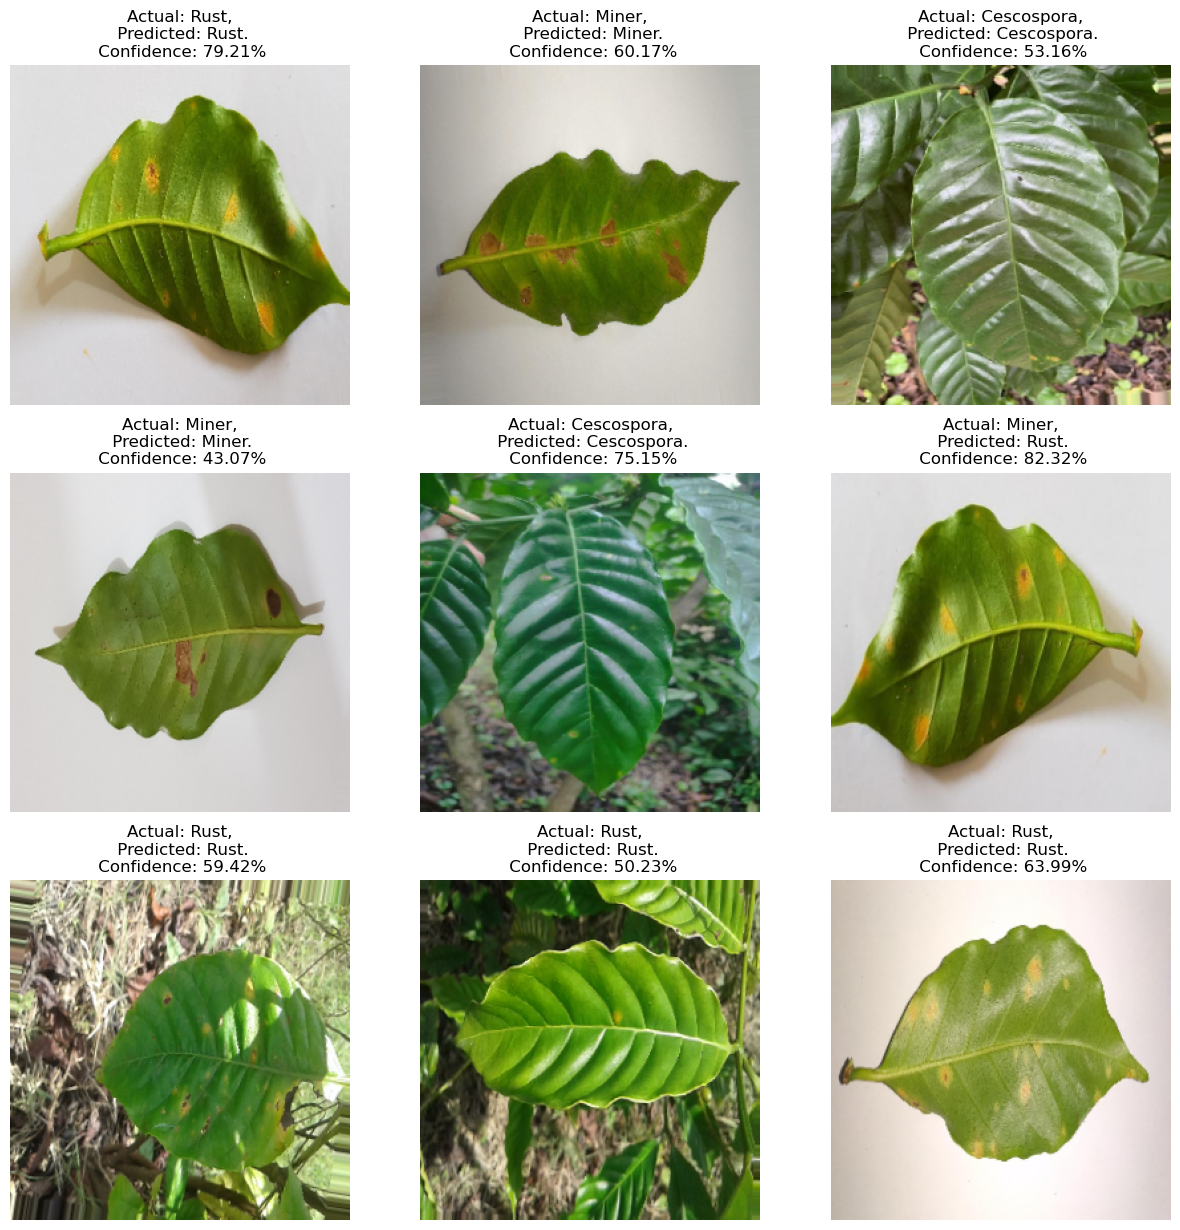

In [195]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model1, images[i])
        actual_class = class_names[int(labels[i])] 
        print(labels)
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [211]:
model1.save("./saved_models/Omdena_model1.h5")

# Model 2: ResNet50

In [166]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
        'data2/output/train',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="categorical",
)

Found 1047 images belonging to 5 classes.


In [167]:
validation_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)
validation_generator = validation_datagen.flow_from_directory(
        'data2/output/val',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="categorical"
)

Found 130 images belonging to 5 classes.


In [168]:
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True)

test_generator = test_datagen.flow_from_directory(
        'data2/output/test',
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=32,
        class_mode="categorical"
)

Found 134 images belonging to 5 classes.


In [169]:
resnet = ResNet50(input_shape=[IMAGE_SIZE] + [IMAGE_SIZE] + [CHANNELS], weights='imagenet', include_top=False)

In [170]:
for layer in resnet.layers:
    layer.trainable = False

In [171]:
resnet.output

<tf.Tensor 'conv5_block3_out/Relu_3:0' shape=(None, 8, 8, 2048) dtype=float32>

In [172]:
x = Flatten()(resnet.output)

In [173]:
folders = glob('data2/output/train/*')

In [174]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model2 = Model(inputs=resnet.input, outputs=prediction)

In [175]:
# view the structure of the model
model2.summary()

Model: "functional_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [176]:
# tell the model what cost and optimization method to use
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [177]:
history = model2.fit(
    train_generator,
    steps_per_epoch=steps,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=5,
)

Epoch 1/5
32/32 [==============================] - 211s 7s/step - loss: 11.2901 - accuracy: 0.2867 - val_loss: 5.4017 - val_accuracy: 0.4077
Epoch 2/5
32/32 [==============================] - 125s 4s/step - loss: 2.2393 - accuracy: 0.4108
Epoch 3/5
32/32 [==============================] - 123s 4s/step - loss: 1.7053 - accuracy: 0.4532
Epoch 4/5
32/32 [==============================] - 131s 4s/step - loss: 1.4253 - accuracy: 0.5074
Epoch 5/5
32/32 [==============================] - 130s 4s/step - loss: 1.3000 - accuracy: 0.5241


In [181]:
scores = model2.evaluate(test_generator)

5/5 [==============================] - 13s 3s/step - loss: 1.8033 - accuracy: 0.4254


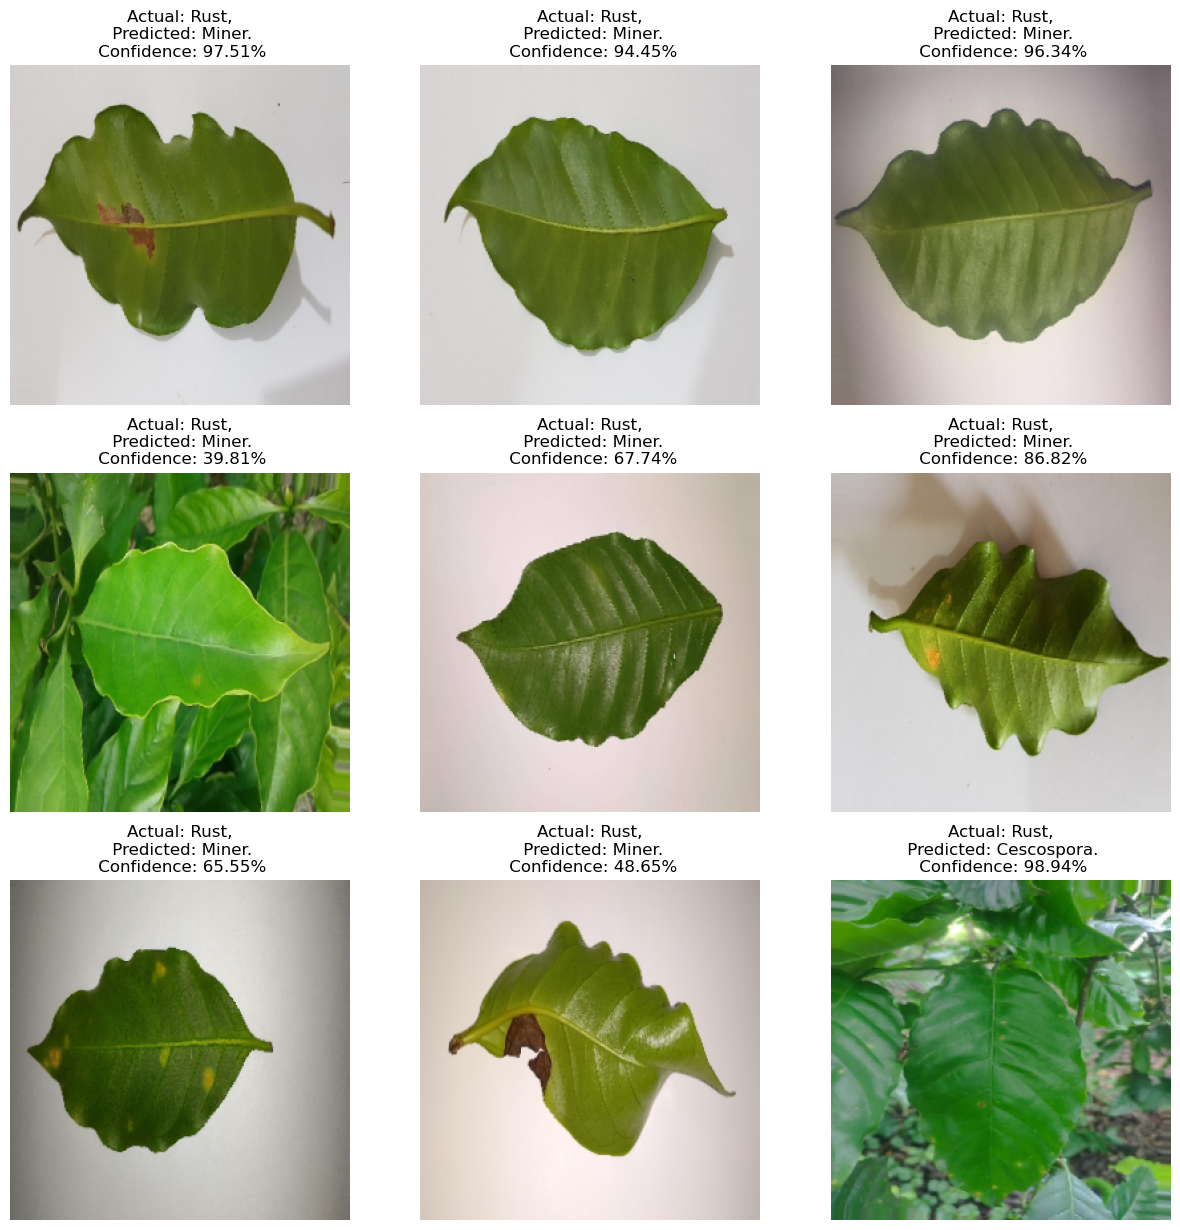

In [197]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model2, images[i])
        actual_class = find_class(labels[i])
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [198]:
model2.save("./saved_models/Omdena_model2.h5")

# Model 3 (InceptionV3)

In [26]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=[IMAGE_SIZE] + [IMAGE_SIZE] + [CHANNELS], weights='imagenet', include_top=False)

In [27]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [28]:
  # useful for getting number of output classes
folders = glob('data2/output/train/*')

In [29]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [30]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model3 = Model(inputs=inception.input, outputs=prediction)

In [31]:
# view the structure of the model
model3.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 127, 127, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d_6[0][0]                   
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [32]:
# tell the model what cost and optimization method to use
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [161]:
history = model3.fit(
    train_generator,
    steps_per_epoch=steps,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=5,
)

Epoch 1/5
32/32 [==============================] - 135s 4s/step - loss: 5.6463 - accuracy: 0.5744 - val_loss: 1.2442 - val_accuracy: 0.7846
Epoch 2/5
32/32 [==============================] - 115s 4s/step - loss: 0.9588 - accuracy: 0.8148
Epoch 3/5
32/32 [==============================] - 121s 4s/step - loss: 0.7184 - accuracy: 0.8631
Epoch 4/5
32/32 [==============================] - 162s 5s/step - loss: 0.3709 - accuracy: 0.9143
Epoch 5/5
32/32 [==============================] - 155s 5s/step - loss: 0.4317 - accuracy: 0.9072


In [162]:
scores = model3.evaluate(test_generator)

5/5 [==============================] - 17s 3s/step - loss: 0.6788 - accuracy: 0.8806


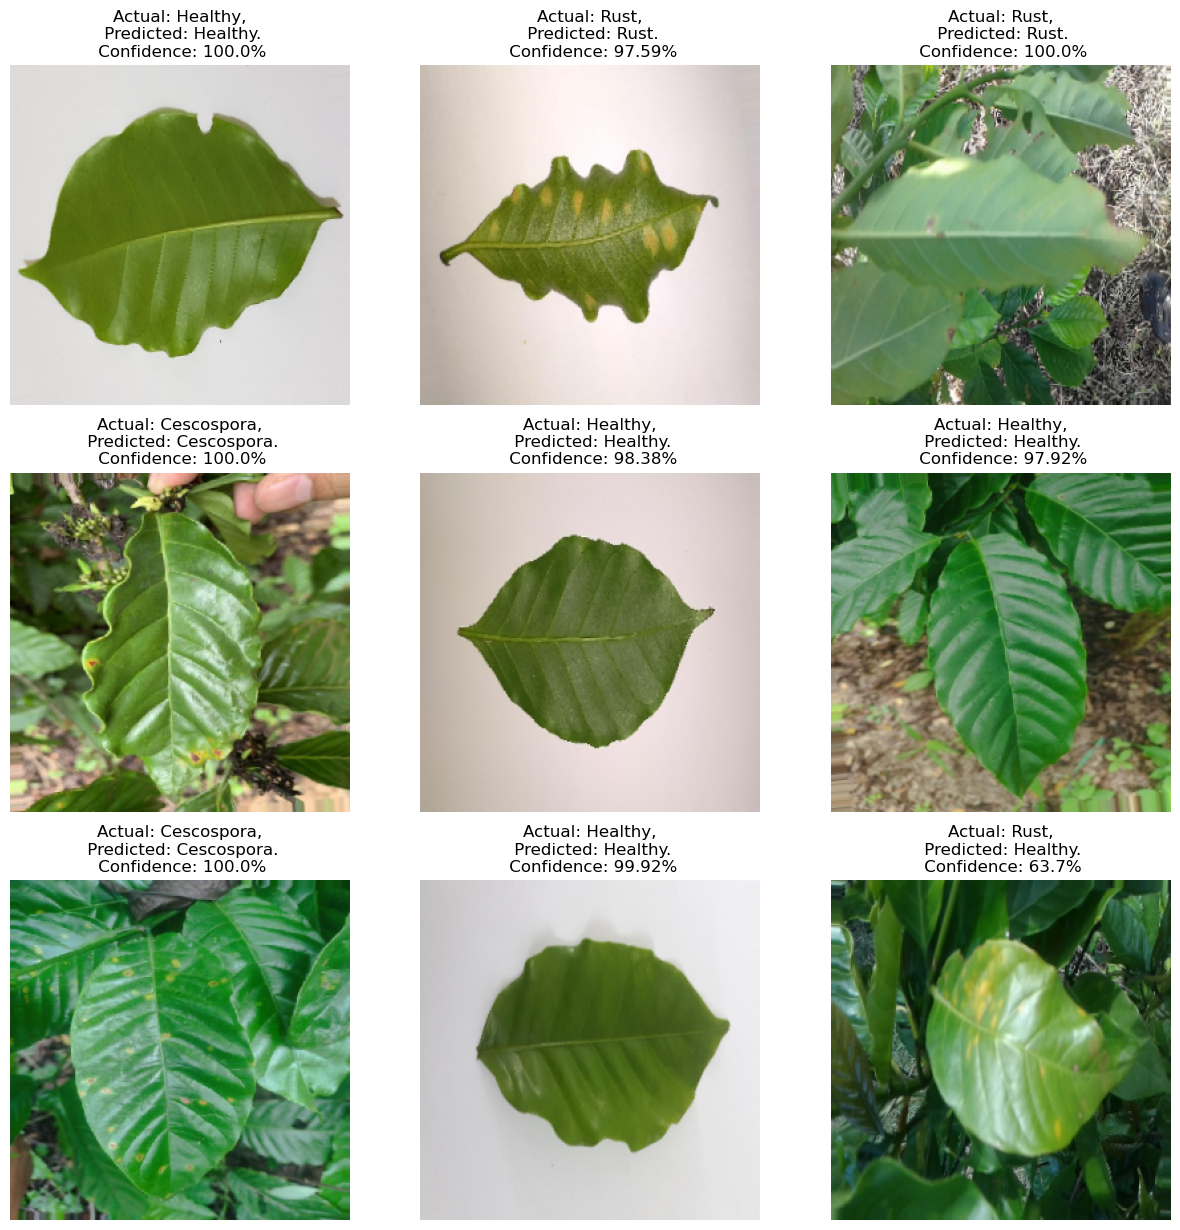

In [163]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model3, images[i])
        actual_class = find_class(labels[i])
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [165]:
model3.save("./saved_models/Omdena_model3.h5")

# Model 4 (mobilenet)

In [33]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

In [34]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

mobile = MobileNetV2(input_shape=[IMAGE_SIZE] + [IMAGE_SIZE] + [CHANNELS], weights='imagenet', include_top=False)

In [35]:
# don't train existing weights
for layer in mobile.layers:
    layer.trainable = False

In [36]:
  # useful for getting number of output classes
folders = glob('data2/output/train/*')

In [37]:
# our layers - you can add more if you want
x = Flatten()(mobile.output)

In [38]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model4 = Model(inputs=mobile.input, outputs=prediction)

In [39]:
# view the structure of the model
model4.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 257, 257, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [40]:
# tell the model what cost and optimization method to use
model4.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [150]:
history = model4.fit(
    train_generator,
    steps_per_epoch=steps,
    batch_size=32,
    validation_data=validation_generator,
    validation_steps=6,
    verbose=1,
    epochs=5,
)

Epoch 1/5
32/32 [==============================] - 105s 3s/step - loss: 2.7354 - accuracy: 0.6946 - val_loss: 1.7578 - val_accuracy: 0.7538
Epoch 2/5
32/32 [==============================] - 90s 3s/step - loss: 0.9334 - accuracy: 0.8778
Epoch 3/5
32/32 [==============================] - 90s 3s/step - loss: 0.7128 - accuracy: 0.9113
Epoch 4/5
32/32 [==============================] - 90s 3s/step - loss: 0.5243 - accuracy: 0.9448
Epoch 5/5
32/32 [==============================] - 90s 3s/step - loss: 0.3638 - accuracy: 0.9448


In [151]:
scores = model4.evaluate(test_generator)

5/5 [==============================] - 9s 2s/step - loss: 1.9181 - accuracy: 0.7836


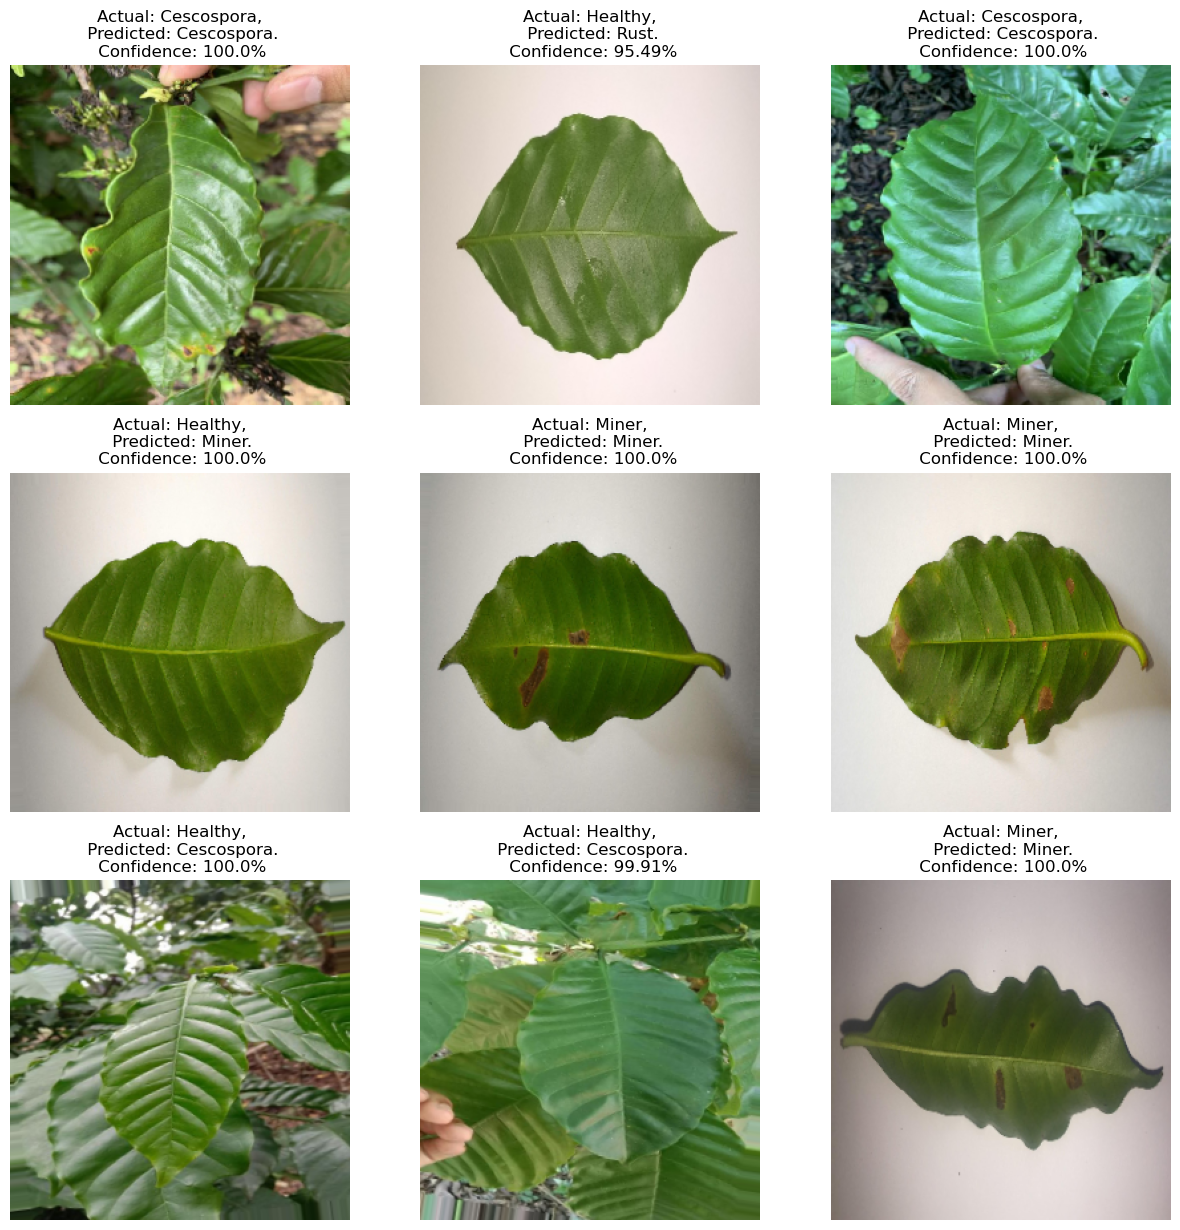

In [152]:
plt.figure(figsize=(15, 15))
for images, labels in test_generator:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        
        predicted_class, confidence = predict(model4, images[i])
        actual_class = find_class(labels[i])
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
    break

In [153]:
model4.save("./saved_models/Omdena_model4.h5")

# Prediction and Confidence Comparison (model 1 vs model 2 vs model 3)

In [ ]:
# Comparision among all base models
for images, labels in test_generator:
    for i in range(1):
        predicted_class1, confidence1 = predict(model1, images[i])
        predicted_class2, confidence2 = predict(model2, images[i])
        predicted_class3, confidence3 = predict(model3, images[i])
        predicted_class4, confidence4 = predict(model4, images[i])
        actual_class = find_class(labels[i])
        print(f"Actual: {actual_class}")
        print(f"Predicted1: {predicted_class1}.\n Confidence1: {confidence1}%")
        print(f"Predicted2: {predicted_class2}.\n Confidence2: {confidence2}%")
        print(f"Predicted3: {predicted_class3}.\n Confidence3: {confidence3}%")
        print(f"Predicted4: {predicted_class4}.\n Confidence3: {confidence4}%")
        print()
    break

# Ensemble (Using Averaging)

In [42]:
for images, labels in test_generator:
    for i in range(1):
        #all_predictions1 = get_all_predictions(model1, images[i])
        #all_predictions2 = get_all_predictions(model2, images[i])
        all_predictions3 = get_all_predictions(model3, images[i])
        all_predictions4 = get_all_predictions(model4, images[i])
#         print(all_predictions3)
        
        actual_class = find_class(labels[i])
        print(f"Actual: {actual_class}")
        
        #final = (all_predictions1 + all_predictions2 + all_predictions3+ all_predictions4)/4
        final = (all_predictions3+ all_predictions4)/2
        predicted_class = class_names[np.argmax(final)]
        print(f"Predicted: {predicted_class}")
    break

Actual: Rust
Predicted: Phoma


In [209]:
tot = 0
corr = 0
for images, labels in test_generator:
    for i in range(len(images)):
        all_predictions1 = get_all_predictions(model1, images[i])
#         all_predictions2 = get_all_predictions(model2, images[i])
#         all_predictions3 = get_all_predictions(model3, images[i])
#         all_predictions4 = get_all_predictions(model4, images[i])
        
        actual_class = find_class(labels[i])
        print(f"Actual: {actual_class}")
        
#         final = (all_predictions1 + all_predictions2 + all_predictions3+ all_predictions4)/4
#         final = (all_predictions3 + all_predictions4)/2
        final = (all_predictions1)/1
        predicted_class = class_names[np.argmax(final)]
        print(f"Predicted: {predicted_class}")
        print()
        if(predicted_class == actual_class):
            corr = corr + 1
        tot = tot + 1
#     break

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Miner

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Miner

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Miner

Actual: Rust
Predicted: Cescospora

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Miner

Actual: Rust
Predicted: Cescospora

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Cescospora

Actual: Rust
Predicted: Healthy

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Cescospora

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Cescospora

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Rust

Actual: Rust
Predicted: Miner

Ac

KeyboardInterrupt: 

In [210]:
print('Accuracy: ', corr/tot)

Accuracy:  0.5823798627002288
